In [120]:
import os
import sys
import cv2
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 


In [121]:
img = cv2.imread('test.png', cv2.IMREAD_COLOR)
img = img.astype(np.float32) / 255
[height, width, _] = img.shape
FOV = 80
wFOV = FOV
THETA = 0    #horizontal
PHI = 90       #vertical
hFOV =  FOV
h = 320
w = 320
w_len = np.tan(np.radians(wFOV / 2.0))
h_len = np.tan(np.radians(hFOV / 2.0))

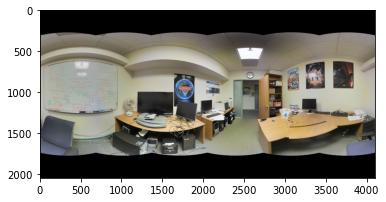

In [122]:
plt.imshow(img[:,:,[2,1,0]])
plt.show()

In [123]:
equ_h = height
equ_w = width
equ_cx = (equ_w - 1) / 2.0
equ_cy = (equ_h - 1) / 2.0

In [124]:
x_map = torch.ones([h, w], dtype=torch.float32)
y_map = torch.linspace(-w_len, w_len, w).unsqueeze(0).repeat(h, 1)
z_map = -torch.linspace(-h_len, h_len, h).unsqueeze(0).repeat(w, 1).transpose(1, 0)

In [125]:
D = torch.sqrt(x_map**2 + y_map**2 + z_map**2)
xyz = torch.stack((x_map,y_map,z_map),dim=2)/ D.unsqueeze(-1).repeat(1, 1, 3)


In [126]:
y_axis = torch.as_tensor([0.0, 1.0, 0.0], dtype=torch.float32)
z_axis = torch.as_tensor([0.0, 0.0, 1.0], dtype=torch.float32)

In [127]:
def rotation_matrix(theta, axis):
    axis = axis / math.sqrt(torch.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    ROT = torch.tensor([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                         [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                         [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]], device='cpu', dtype=torch.float32)
    return ROT

In [128]:
R1 = rotation_matrix(math.radians(THETA), z_axis)
R2 = rotation_matrix(math.radians(-PHI), torch.matmul(R1, y_axis))

In [129]:
xyz = xyz.view(h * w, 3).transpose(1, 0)
xyz = torch.matmul(R1, xyz)
xyz = torch.matmul(R2, xyz).transpose(1, 0)
lat = torch.asin(xyz[:, 2])
lon = torch.atan2(xyz[:, 1] , xyz[:, 0])

In [130]:
lon = lon.view(h, w) / math.pi * 180
lat = -lat.view(h, w) / math.pi * 180

In [131]:
lon = lon / 180 * equ_cx + equ_cx
lat = lat / 90  * equ_cy + equ_cy

In [132]:
print(lat.min(), lat.max())

tensor(2.4335) tensor(567.2381)


In [133]:
lon = (lon / width - 0.5)*2
lat = (lat / height - 0.5)*2

In [134]:
grid = torch.stack([lon, lat], -1)
grid = grid.unsqueeze(0)
img = img.transpose(2, 0, 1)
img = torch.from_numpy(img).unsqueeze(0)

In [135]:
persp = F.grid_sample(img, grid, mode='bilinear', padding_mode='zeros',align_corners=True)

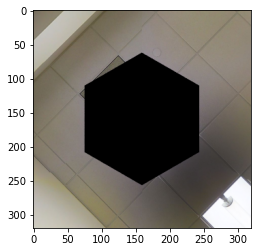

In [136]:
persp = persp[0].permute(1, 2, 0).numpy()
persp_int = persp * 255
plt.imshow(persp_int[:,:,[2,1,0]].astype(np.uint8))
plt.show()